# Разностное решение уравнения колебаний (схема с весами σ)

Рассматривается задача Коши для уравнения
$$
u_{tt} = u_{xx} + f(x, t), \quad 0 < x < 1,\ t > 0,
$$
с начально-граничными условиями
$$
u(x, 0) = \varphi(x), \quad u_t(x, 0) = \psi(x),
$$
$$
u(0, t) = \mu_1(t), \quad u(1, t) = \mu_2(t).
$$

Используется двухшаговая по времени и трёхточечная по пространству схема с весами σ (формулы (4), (5), (16) из раздатки) для уравнения колебаний.

Для теста берём аналитическое решение
$$
u(x,t) = \cos(\pi x)\cos(\pi t),
$$
для которого
- $f(x,t) \equiv 0$,
- $\varphi(x) = \cos(\pi x)$,
- $\psi(x) = 0$,
- $\mu_1(t) = \cos(\pi t),\ \mu_2(t) = -\cos(\pi t)$.

Ниже реализована схема, построены графики численного решения, аналитического решения и ошибки, а также проведён тест сходимости по пространственному шагу $h$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 12

In [2]:
def u_analytic(x, t):
    return np.cos(np.pi * x) * np.cos(np.pi * t)


def phi(x):
    return np.cos(np.pi * x)


def psi(x):
    return 0.0 * x


def mu1(t):
    return np.cos(np.pi * t)


def mu2(t):
    return -np.cos(np.pi * t)


def f_rhs(x, t):
    return 0.0 * x

In [3]:
def solve_tridiagonal(a, c, b, d):
    n = len(c)
    ac = a.copy().astype(float)
    bc = b.copy().astype(float)
    cc = c.copy().astype(float)
    dc = d.copy().astype(float)

    for i in range(1, n):
        w = ac[i] / cc[i - 1]
        cc[i] = cc[i] - w * bc[i - 1]
        dc[i] = dc[i] - w * dc[i - 1]

    x = np.empty(n, dtype=float)
    x[-1] = dc[-1] / cc[-1]
    for i in range(n - 2, -1, -1):
        x[i] = (dc[i] - bc[i] * x[i + 1]) / cc[i]
    return x

In [4]:
def solve_wave_sigma(
    sigma=0.0,
    N=100,
    T_max=3.0,
    tau=0.01,
    k=1.0,
):
    h = 1.0 / N
    M = int(round(T_max / tau))
    tau = T_max / M

    x = np.linspace(0.0, 1.0, N + 1)
    t_grid = np.linspace(0.0, T_max, M + 1)

    # y_prev: слой t = 0
    y_prev = phi(x)
    y_prev[0] = mu1(0.0)
    y_prev[-1] = mu2(0.0)

    # y_curr: слой t = tau (аппроксимация начального условия второго порядка)
    y_curr = np.empty_like(y_prev)
    t1 = tau
    y_curr[0] = mu1(t1)
    y_curr[-1] = mu2(t1)
    for i in range(1, N):
        xi = x[i]
        lap_phi = (phi(xi - h) - 2.0 * phi(xi) + phi(xi + h)) / (h * h)
        y_curr[i] = (
            phi(xi)
            + tau * psi(xi)
            + 0.5 * tau * tau * (k * lap_phi + f_rhs(xi, 0.0))
        )

    snapshots_numeric = [y_prev.copy(), y_curr.copy()]
    snapshots_analytic = [
        u_analytic(x, 0.0),
        u_analytic(x, t1),
    ]
    snapshot_times = [0.0, t1]

    r = sigma * k * tau * tau / (h * h)

    K = N - 1
    a = np.zeros(K)
    b = np.zeros(K)
    c = np.zeros(K)

    if sigma != 0.0:
        a[1:] = -r
        b[:-1] = -r
        c[:] = 1.0 + 2.0 * r
    else:
        c[:] = 1.0

    y_old = y_prev
    y_now = y_curr

    for n in range(1, M):
        t_n = n * tau
        t_np1 = (n + 1) * tau

        y_next = np.empty_like(y_now)
        y_next[0] = mu1(t_np1)
        y_next[-1] = mu2(t_np1)

        rhs = np.empty(K)
        for j in range(K):
            i = j + 1
            xi = x[i]

            lap_now = (y_now[i + 1] - 2.0 * y_now[i] + y_now[i - 1]) / (h * h)
            lap_old = (y_old[i + 1] - 2.0 * y_old[i] + y_old[i - 1]) / (h * h)

            rhs_i = (
                2.0 * y_now[i]
                - y_old[i]
                + tau * tau
                * (
                    (1.0 - 2.0 * sigma) * k * lap_now
                    + sigma * k * lap_old
                    + f_rhs(xi, t_n)
                )
            )

            rhs[j] = rhs_i

        if sigma != 0.0:
            rhs[0] += r * y_next[0]
            rhs[-1] += r * y_next[-1]
            interior = solve_tridiagonal(a, c, b, rhs)
        else:
            interior = rhs

        y_next[1:-1] = interior

        y_old, y_now = y_now, y_next

        if n in (M // 3, 2 * M // 3, M):
            snapshots_numeric.append(y_now.copy())
            snapshots_analytic.append(u_analytic(x, t_np1))
            snapshot_times.append(t_np1)

    return {
        "x": x,
        "t": t_grid,
        "numeric": y_now,
        "snapshots_numeric": np.array(snapshots_numeric),
        "snapshots_analytic": np.array(snapshots_analytic),
        "snapshot_times": np.array(snapshot_times),
    }

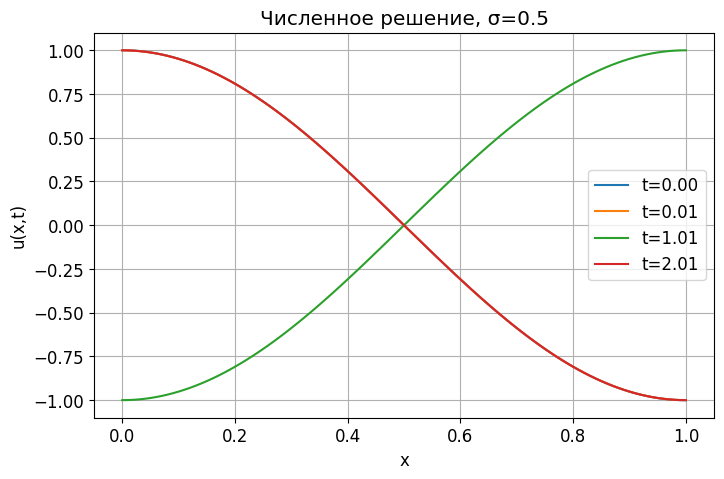

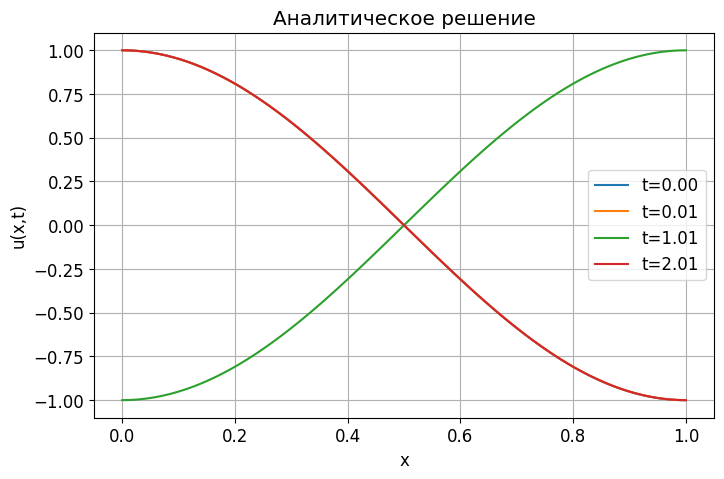

In [5]:
params = dict(
    sigma=0.5,
    N=100,
    T_max=3.0,
    tau=0.01,
    k=1.0,
)

res = solve_wave_sigma(**params)
x = res["x"]
snap_num = res["snapshots_numeric"]
snap_anal = res["snapshots_analytic"]
times = res["snapshot_times"]

plt.figure()
for i, t_val in enumerate(times):
    plt.plot(x, snap_num[i], label=f"t={t_val:.2f}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(f"Численное решение, σ={params['sigma']}")
plt.grid(True)
plt.legend()

plt.figure()
for i, t_val in enumerate(times):
    plt.plot(x, snap_anal[i], label=f"t={t_val:.2f}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Аналитическое решение")
plt.grid(True)
plt.legend()

t_final = 2.0100000000000002
max |error| = 1.9179884281905757e-06


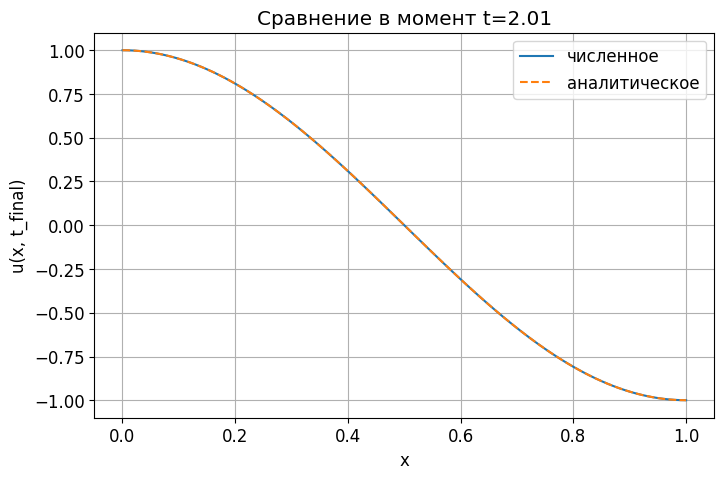

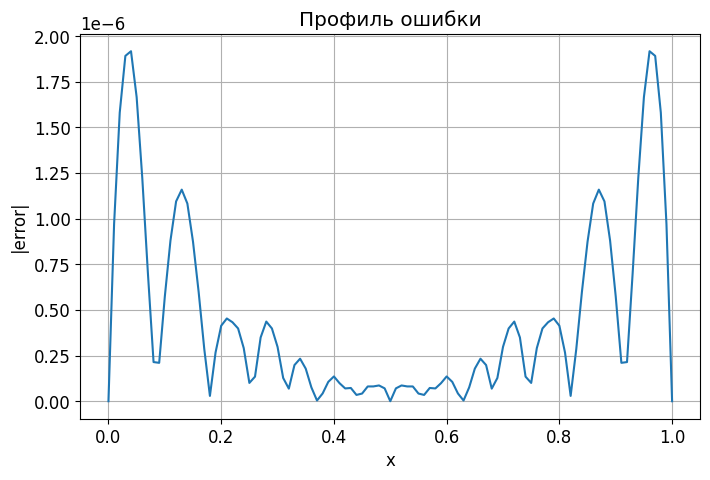

In [6]:
t_final = times[-1]
num_final = snap_num[-1]
anal_final = snap_anal[-1]
error = np.abs(num_final - anal_final)

print("t_final =", t_final)
print("max |error| =", error.max())

plt.figure()
plt.plot(x, num_final, label="численное")
plt.plot(x, anal_final, linestyle="--", label="аналитическое")
plt.xlabel("x")
plt.ylabel("u(x, t_final)")
plt.title(f"Сравнение в момент t={t_final:.2f}")
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(x, error)
plt.xlabel("x")
plt.ylabel("|error|")
plt.title("Профиль ошибки")
plt.grid(True)

N=  50, h=0.02000, tau=0.01000, max|error|=8.22084e-06
N= 100, h=0.01000, tau=0.00500, max|error|=2.45385e-06
N= 200, h=0.00500, tau=0.00250, max|error|=4.51005e-07
N= 400, h=0.00250, tau=0.00125, max|error|=1.17287e-07
Оценка порядка по h ≈ 2.083732695032615


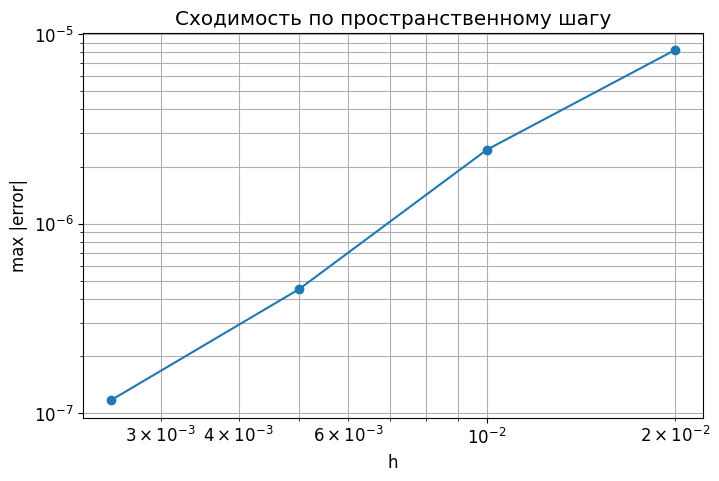

In [7]:
def run_error_vs_h(
    sig=0.5,
    T_max=1.0,
    CFL=0.5,
    Ns=(50, 100, 200, 400),
):
    hs = []
    errs = []
    for N in Ns:
        h = 1.0 / N
        tau = CFL * h
        res = solve_wave_sigma(
            sigma=sig,
            N=N,
            T_max=T_max,
            tau=tau,
            k=1.0,
        )
        x = res["x"]
        t_final = res["snapshot_times"][-1]
        num = res["snapshots_numeric"][-1]
        anal = u_analytic(x, t_final)
        err = np.max(np.abs(num - anal))
        hs.append(h)
        errs.append(err)
        print(f"N={N:4d}, h={h:.5f}, tau={tau:.5f}, max|error|={err:.5e}")
    return np.array(hs), np.array(errs)


hs, errs = run_error_vs_h()

plt.figure()
plt.loglog(hs, errs, marker="o")
plt.xlabel("h")
plt.ylabel("max |error|")
plt.title("Сходимость по пространственному шагу")
plt.grid(True, which="both")

order = np.polyfit(np.log(hs), np.log(errs), 1)[0]
print("Оценка порядка по h ≈", order)